# 1. Notebook Title & Purpose

# Sprint History Notebook

This notebook reconstructs sprint histories using sovereign forensic telemetry extracted from the local `.git` repository.

It provides:
- Sprint filtering by date boundaries
- Velocity, cadence, and flow efficiency metrics
- Visualizations of commit activity and scope evolution
- Narrative scaffolding for governance reporting

This notebook is a standing artifact of governance evidence.


In [13]:
import os

# Move working directory from notebooks/ to repo root
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print("Current working directory:", os.getcwd())


Current working directory: /home/ian/dev/knowledge-ecosystem


# 2. Imports & Data Loading

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz

# New Zealand timezone (handles DST automatically)
NZ = pytz.timezone("Pacific/Auckland")

def nzdt(dt):
    """
    Convert a naive datetime to a timezone-aware datetime
    in the Pacific/Auckland timezone.
    """
    return NZ.localize(dt)


# Load sovereign forensic dataset
df = pd.read_parquet("data/forensics.parquet")

# Ensure timestamps are datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])


# 3. Define Sprint Boundaries

In [15]:
sprints = {
    "Sprint 01": {
        "start": nzdt(datetime(2026, 1, 5, 0, 0)),
        "end":   nzdt(datetime(2026, 1, 11, 23, 59))
    },
    "Sprint 02": {
        "start": nzdt(datetime(2026, 1, 12, 0, 0)),
        "end":   nzdt(datetime(2026, 1, 18, 23, 59))
    },
    "Sprint 03": {
        "start": nzdt(datetime(2026, 1, 19, 0, 0)),
        "end":   nzdt(datetime(2026, 1, 25, 23, 59))
    }
}


# 4. Sprint Filtering Function

In [16]:
def filter_sprint(df, sprint_name):
    s = sprints[sprint_name]
    return df[(df["timestamp"] >= s["start"]) & (df["timestamp"] <= s["end"])]


# 5. Metric Computation

In [17]:
def compute_metrics(df_sprint):
    metrics = {}

    # Velocity
    metrics["commit_count"] = df_sprint["commit_hash"].nunique()
    metrics["files_touched"] = df_sprint["file_path"].nunique()
    metrics["lines_added"] = df_sprint["lines_added"].fillna(0).sum()
    metrics["lines_removed"] = df_sprint["lines_removed"].fillna(0).sum()

    # Cadence
    df_unique = df_sprint.drop_duplicates("commit_hash").sort_values("timestamp")
    df_unique["delta"] = df_unique["timestamp"].diff()
    metrics["average_cadence"] = df_unique["delta"].mean()

    # Flow efficiency
    deltas = df_unique["delta"].dropna()
    if len(deltas) > 0:
        active = deltas.min()
        idle = deltas.sum() - active
        metrics["flow_efficiency"] = active / (active + idle)
    else:
        metrics["flow_efficiency"] = None

    return metrics


# 6. Visualizations

## Commit Timeline

In [18]:
def plot_commit_timeline(df_sprint, sprint_name):
    df_unique = df_sprint.drop_duplicates("commit_hash")
    plt.figure(figsize=(12, 4))
    plt.scatter(df_unique["timestamp"], [1]*len(df_unique), alpha=0.7)
    plt.title(f"Commit Timeline — {sprint_name}")
    plt.yticks([])
    plt.xlabel("Time")
    plt.show()


## Lines Added/Removed Over Time

In [19]:
def plot_scope_evolution(df_sprint, sprint_name):
    df_unique = df_sprint.drop_duplicates("commit_hash")
    df_unique = df_unique.sort_values("timestamp")

    plt.figure(figsize=(12, 5))
    plt.plot(df_unique["timestamp"], df_unique["lines_added"].fillna(0), label="Lines Added")
    plt.plot(df_unique["timestamp"], df_unique["lines_removed"].fillna(0), label="Lines Removed")
    plt.title(f"Scope Evolution — {sprint_name}")
    plt.legend()
    plt.show()


# 7. Sprint Reconstruction Loop


=== Sprint 01 ===
commit_count: 31
files_touched: 181
lines_added: 5249
lines_removed: 132
average_cadence: 0 days 05:11:36
flow_efficiency: 0.0001782912565967765


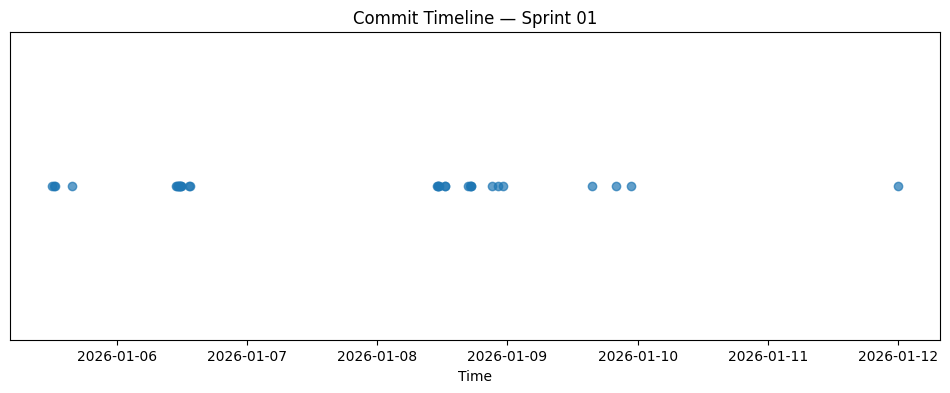

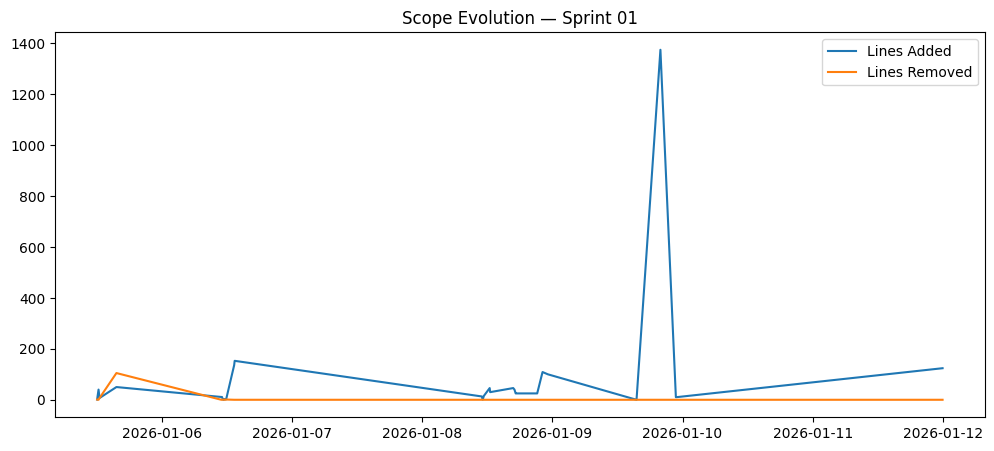


=== Sprint 02 ===
commit_count: 13
files_touched: 16
lines_added: 1607
lines_removed: 23
average_cadence: 0 days 11:00:58.333333333
flow_efficiency: 0.0008237024584996848


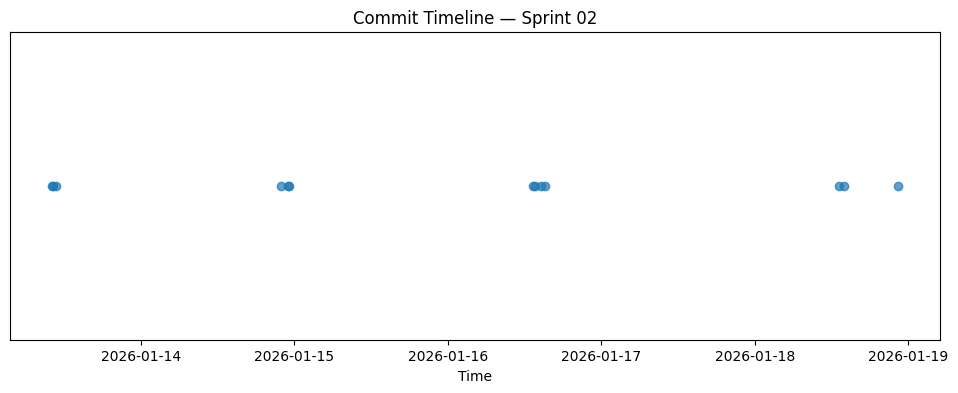

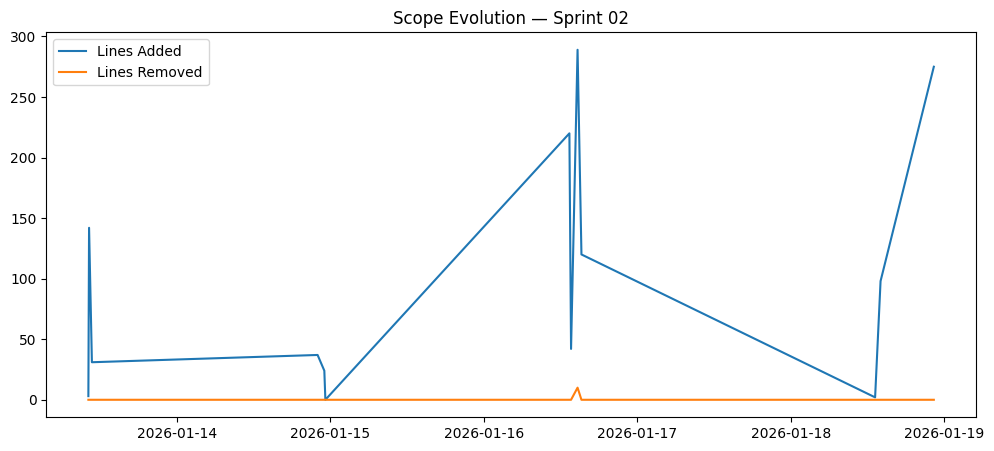


=== Sprint 03 ===
commit_count: 0
files_touched: 0
lines_added: 0
lines_removed: 0
average_cadence: NaT
flow_efficiency: None


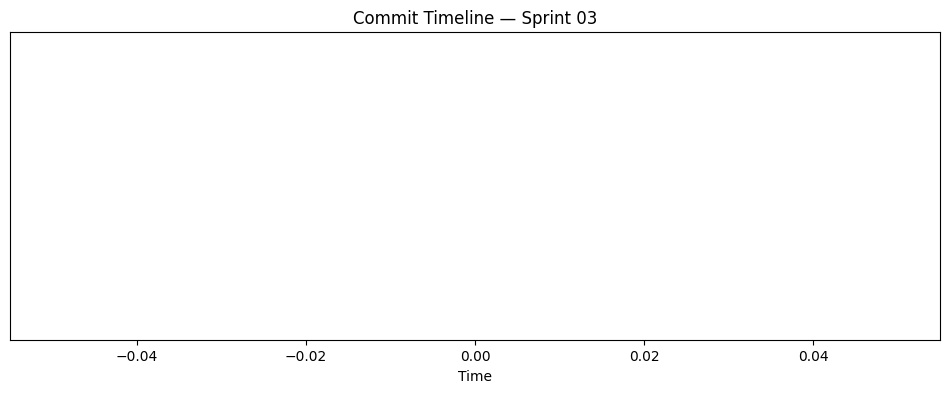

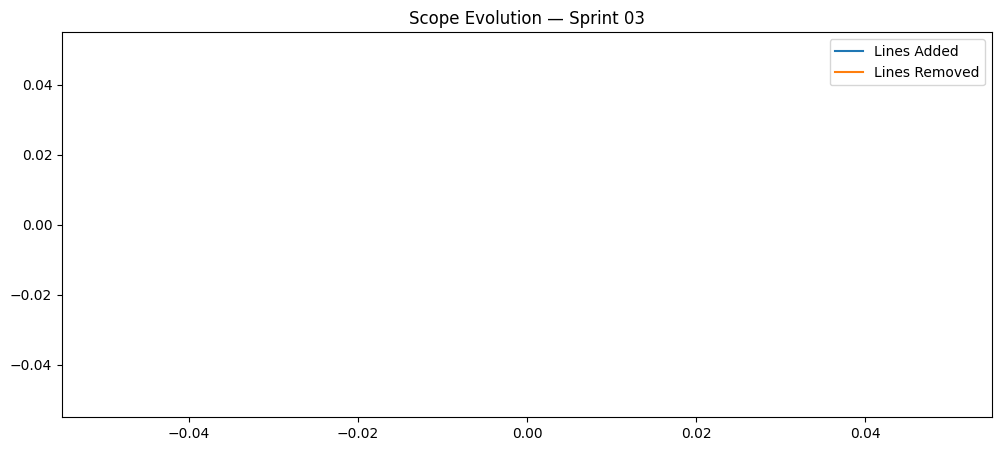

In [20]:
all_metrics = {}

for sprint_name in sprints.keys():
    df_sprint = filter_sprint(df, sprint_name)
    metrics = compute_metrics(df_sprint)
    all_metrics[sprint_name] = metrics

    print(f"\n=== {sprint_name} ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    plot_commit_timeline(df_sprint, sprint_name)
    plot_scope_evolution(df_sprint, sprint_name)


## Convert Sprint Metrics into a DataFrame

In [21]:
# Convert metrics dictionary into a DataFrame for trend analysis
metrics_df = pd.DataFrame(all_metrics).T

# Ensure the index is ordered by sprint number
metrics_df.index.name = "Sprint"
metrics_df = metrics_df.sort_index()

metrics_df


,commit_count,files_touched,lines_added,lines_removed,average_cadence,flow_efficiency
Sprint,,,,,,
Sprint 01,31,181,5249,132,0 days 05:11:36,0.000178
Sprint 02,13,16,1607,23,0 days 11:00:58.333333333,0.000824
Sprint 03,0,0,0,0,NaT,None


## Velocity Trend Chart

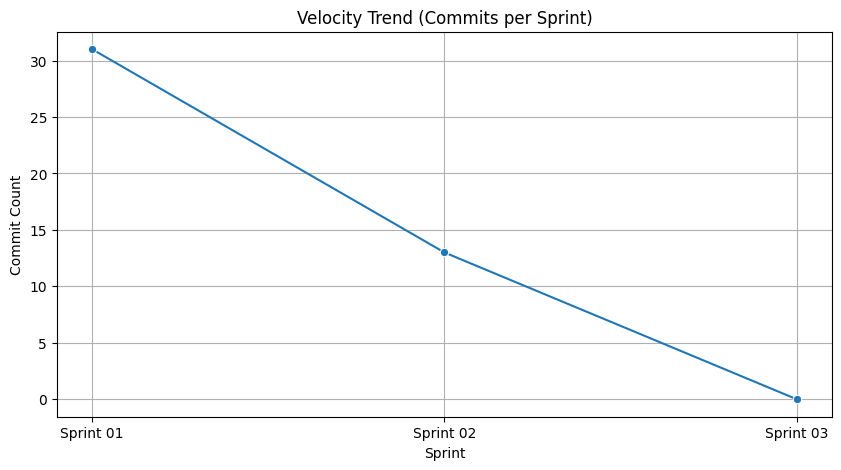

In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x=metrics_df.index, y="commit_count", marker="o")
plt.title("Velocity Trend (Commits per Sprint)")
plt.xlabel("Sprint")
plt.ylabel("Commit Count")
plt.grid(True)
plt.show()


## Files Touched Trend

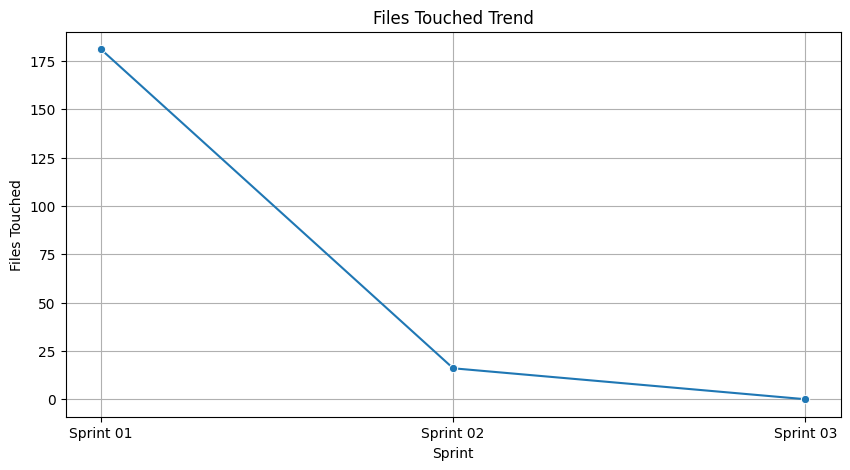

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x=metrics_df.index, y="files_touched", marker="o")
plt.title("Files Touched Trend")
plt.xlabel("Sprint")
plt.ylabel("Files Touched")
plt.grid(True)
plt.show()


## Lines Added/Removed Trend

This shows how much construction vs. cleanup each sprint involved.

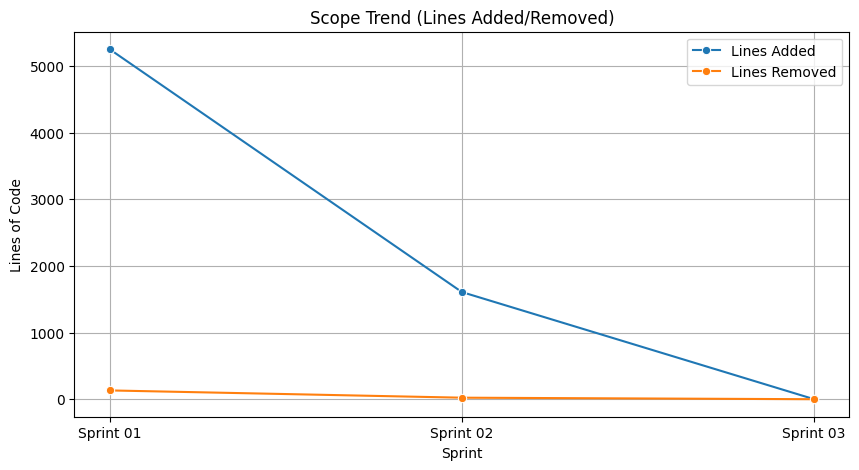

In [24]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x=metrics_df.index, y="lines_added", marker="o", label="Lines Added")
sns.lineplot(data=metrics_df, x=metrics_df.index, y="lines_removed", marker="o", label="Lines Removed")
plt.title("Scope Trend (Lines Added/Removed)")
plt.xlabel("Sprint")
plt.ylabel("Lines of Code")
plt.legend()
plt.grid(True)
plt.show()


## Cadence Trend Chart

Cadence is a Timedelta, so we convert it to hours:

In [ ]:
# Convert average_cadence to Timedelta, coercing non-timedelta values to NaT
metrics_df["average_cadence"] = pd.to_timedelta(metrics_df["average_cadence"], errors="coerce")
metrics_df["cadence_hours"] = metrics_df["average_cadence"].dt.total_seconds() / 3600

plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x=metrics_df.index, y="cadence_hours", marker="o")
plt.title("Cadence Trend (Average Hours Between Commits)")
plt.xlabel("Sprint")
plt.ylabel("Hours")
plt.grid(True)
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values

## Flow Efficiency Trend Chart

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x=metrics_df.index, y="flow_efficiency", marker="o")
plt.title("Flow Efficiency Trend")
plt.xlabel("Sprint")
plt.ylabel("Flow Efficiency")
plt.grid(True)
plt.show()


## Composite Dashboard

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.lineplot(ax=axes[0,0], data=metrics_df, x=metrics_df.index, y="commit_count", marker="o")
axes[0,0].set_title("Velocity")

sns.lineplot(ax=axes[0,1], data=metrics_df, x=metrics_df.index, y="files_touched", marker="o")
axes[0,1].set_title("Files Touched")

sns.lineplot(ax=axes[1,0], data=metrics_df, x=metrics_df.index, y="cadence_hours", marker="o")
axes[1,0].set_title("Cadence (Hours)")

sns.lineplot(ax=axes[1,1], data=metrics_df, x=metrics_df.index, y="flow_efficiency", marker="o")
axes[1,1].set_title("Flow Efficiency")

plt.tight_layout()
plt.show()


8. Narrative Scaffolding

# Sprint Narrative

## Sprint 01 Summary
- Throughput:
- Cadence:
- Flow efficiency:
- Scope evolution:
- Key themes:
- Observations:
- Governance implications:

## Sprint 02 Summary
- Throughput:
- Cadence:
- Flow efficiency:
- Scope evolution:
- Key themes:
- Observations:
- Governance implications:

## Sprint 03 Summary
- Throughput:
- Cadence:
- Flow efficiency:
- Scope evolution:
- Key themes:
- Observations:
- Governance implications:


This section becomes the human-authored governance layer, supported by sovereign telemetry.

# Why This Notebook Matters

We now have:  
* a time‑series governance artifact  
* a repeatable sprint reconstruction engine  
* a visual analytics layer  
* a narrative scaffold for sprint reviews  
* a permanent evidence base for your practice  